# **StarGAN - CelebA**

In [1]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import itertools
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random

In [2]:
workers = 2
batch_size = 64
image_size = 128
n_attr = 4

epochs = 50
lr = 0.0001
beta1, beta2 = 0.5, 0.999
n_critic = 5
lamb_cls, lamb_gp, lamb_rec, lamb_mask = 1, 10, 5, 8
n_ep_decay = 25
lr_update_step = 1000
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "./model"

print("Device: ", end="")
print(device)

Device: cuda:0


In [4]:
# Download CelebA image files from kaggle
# !! Only run if there is no image files !!
# !! kaggle.json is needed !!

import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
    print("Already kaggle.json exsits.")
else:
    !mkdir -p ~/.kaggle
    !cp ./kaggle.json ~/.kaggle/ 
    !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d surendrakc/celebamaskhq
if os.path.isdir('./CelebAMask-HQ'):
    print("Already unzip.")
else:
    !unzip -q celebamaskhq.zip
    print("Unzip Complete!")

cp: cannot stat './kaggle.json': No such file or directory
100%|██████████████████████████████████████▊| 2.92G/2.94G [00:16<00:00, 209MB/s]
100%|███████████████████████████████████████| 2.94G/2.94G [00:16<00:00, 195MB/s]
Unzip Complete!


In [138]:
class CelebAwithMask(torch.utils.data.Dataset):
    def __init__(self, attr_idx, transform=None, length=None):
        self.attr_dict = {}
        with open('./CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt','r') as f:
            line = f.readline()
            line = f.readline()
            while True:
                line = f.readline()
                if not line:
                    break
                line = line.replace('  ',' ').replace('\n','').split(' ')
                temp_list = []
                for idx in attr_idx:
                    if line[idx] == '1':
                        temp_list.append(1)
                    elif line[idx] == '-1':
                        temp_list.append(0)
                self.attr_dict[line[0]] = temp_list
        
        self.paths = glob('./CelebAMask-HQ/CelebA-HQ-img/*.jpg')
        self.transform = transform
        self.length = len(self.paths)
        
        if length:
            random.shuffle(self.paths)
            self.paths = self.paths[:length]
            self.length = length
        
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        
        filename = self.paths[index].split('/')[-1]
        label = self.attr_dict[filename]
        label = torch.FloatTensor(label)
        
        masknum = int(filename.replace('.jpg',''))
        maskdir = str(masknum // 2000)
        maskpaths = glob('./CelebAMask-HQ/CelebAMask-HQ-mask-anno/%s/%05d_*.png' % (maskdir, masknum))
        mask = np.zeros((512,512,3), dtype=np.uint8)
        for idx, path in enumerate(maskpaths):
            if path.find('cloth') == -1:
                mask = mask + cv2.imread(path)
        
        resize = transforms.Compose([transforms.ToTensor(), transforms.Resize(image_size)])
                
        mask = resize(255-mask)
        
        if self.transform:
            img = self.transform(img)
            
        return img, label, mask

    def __len__(self):
        return self.length

# Restore images to suitable images of opencv style
def ImgForPlot(img):
    img = np.einsum('ijk->jki', img)
    img = (127.5*(img+1)).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [139]:
# Black_Hair, Blond_Hair, Male, Young
attr_idx = [9, 10, 21, 40]

transform=transforms.Compose([transforms.ToTensor(),
                            transforms.Resize(image_size),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    
dataset = CelebAwithMask(attr_idx=attr_idx, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

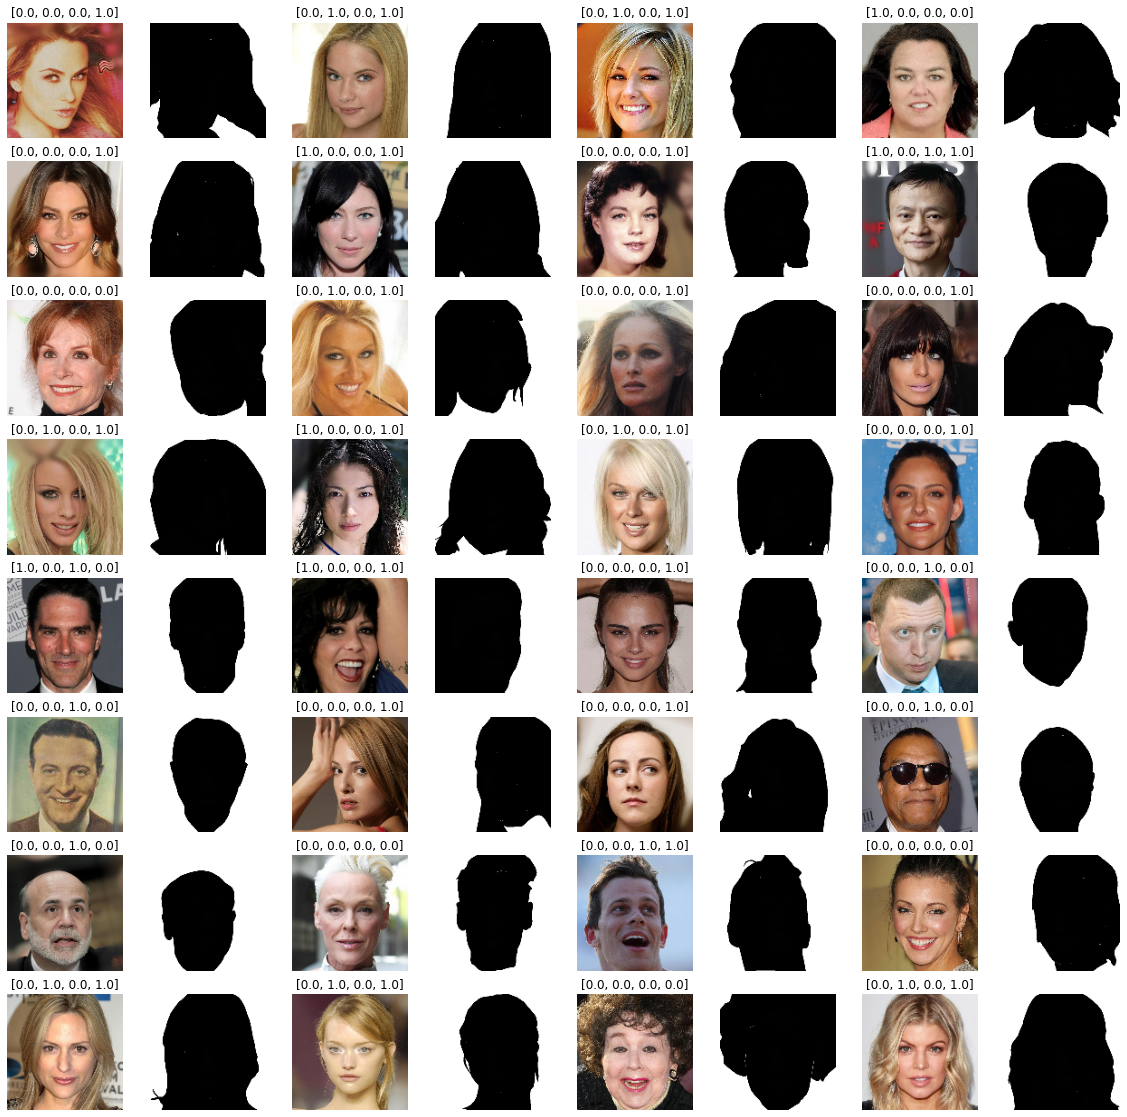

In [140]:
fig = plt.figure(figsize=(20,20))

for k in range(32):
    img, idx, mask = dataset[k]
    ax = fig.add_subplot(8, 8, 2*k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    ax.set_title(idx.tolist())
    ax = fig.add_subplot(8, 8, 2*k+2)
    ax.imshow((np.einsum('ijk->jki', mask)*255.0).astype(np.uint8))
    ax.axis("off")

plt.show()

# Generator

In [141]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [142]:
class Res_Block(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Res_Block, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True)
        )

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    def __init__(self, ngf=64, nc=4, n_res_block=6):
        super(Generator, self).__init__()
        self.n_res_block = n_res_block
        self.enc = nn.Sequential(
            # 128x128x7
            nn.Conv2d(3+nc, ngf, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(ngf, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 128x128x64
            nn.Conv2d(ngf, ngf*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 64x64x128
            nn.Conv2d(ngf*2, ngf*4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*4, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            # 32x32x256
        )

        self.dec = nn.Sequential(
            # 32x32x256
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 64x64x128
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 128x128x64
            nn.Conv2d(ngf, 3, 7, 1, 3, bias=False),
            nn.Tanh()
            # 128x128x3
        )

        self.res = nn.ModuleList()
        for _ in range(n_res_block):
            block = Res_Block(ngf*4, ngf*4).to(device)
            block.apply(weights_init)
            self.res.append(block)

    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        
        x = self.enc(x)
        
        for i in range(self.n_res_block):
            x = self.res[i](x)
            
        return self.dec(x)

# Discriminator

In [143]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=4):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.main = nn.Sequential(
            # 128x128x3
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 64x64x64
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 32x32x128
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 16x16x256
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 8x8x512
            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 4x4x1024
            nn.Conv2d(ndf*16, ndf*32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 2x2x2048
        )
        self.conv1 = nn.Conv2d(ndf*32, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf*32, nc, kernel_size=2, bias=False)

    def forward(self, x):
        x = self.main(x)        
        return self.conv1(x), self.conv2(x).view(-1, self.nc)

## Gradient Penalty

In [144]:
def calc_gradient_penalty(b_size, netD, real_data, fake_data):
    alpha = torch.rand(b_size, 1, 1, 1)
    alpha = alpha.cuda()

    interpolates = real_data + alpha * (fake_data - real_data)
    interpolates = Variable(interpolates, requires_grad=True).cuda()

    disc_interpolates, _ = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True)[0].view(interpolates.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

## Making models & Weight initialization

In [145]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [146]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv1): Conv2d(2048, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2):

## (Option) Load models and lists

In [ ]:
model_name = 'StarGAN-mask_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
fixed_path = F"{model_saved_dir}/{model_name}_fixed.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

with open(img_list_path, 'rb') as f:
    img_list = pickle.load(f)
with open(losses_path, 'rb') as f:
    G_losses, D_losses = pickle.load(f)
with open(fixed_path, 'rb') as f:
    fixed_image, fixed_label = pickle.load(f)

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))

## Optimizers

In [148]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,beta2))

def update_lr(g_lr, d_lr):
    for param_group in optimizerG.param_groups:
        param_group['lr'] = g_lr
    for param_group in optimizerD.param_groups:
        param_group['lr'] = d_lr

## Training

In [149]:
model_name = 'StarGAN-mask_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
fixed_path = F"{model_saved_dir}/{model_name}_fixed.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

start_epoch = 0
continueTrain = False

if start_epoch == 0 and not continueTrain:
    img_list, G_losses, D_losses = [], [], []
    fixed_image = []
    fixed_label = []
    for i in range(5):
        img, label, _ = dataset[i]
        for j in range(4):
            fixed_image.append(img)
            label[j] = 1.0 - label[j]
            fixed_label.append(label.clone().detach())
            label[j] = 1.0 - label[j]
    fixed_image = torch.stack(fixed_image)
    fixed_label = torch.stack(fixed_label)
    with open(fixed_path, 'wb') as f:
        pickle.dump((fixed_image, fixed_label), f)
    print("Created validation set")
    
if start_epoch >= n_ep_decay:
    now_lr = lr * (1 - (start_epoch - n_ep_decay)/(epochs - n_ep_decay))
    update_lr(now_lr, now_lr)
    print('Learning Rate decayed: %.4e' % now_lr)
    
netD.train()
netG.train()
fixed_image = fixed_image.cuda()
fixed_label = fixed_label.cuda()

for ep in range(start_epoch, epochs):
    for batch_idx, (image, label, mask) in enumerate(dataloader, 0):
        step = ep * len(dataloader) + batch_idx + 1

        b_size = image.shape[0]
        image = Variable(image).cuda()
        target_label = label[torch.randperm(b_size)]
        label = Variable(label).cuda()
        target_label = Variable(target_label).cuda()
        mask = Variable(mask).cuda()

        # 1. Update Discriminator
        output, cls = netD(image)
        errD_real = -output.mean()
        errD_cls = F.binary_cross_entropy_with_logits(cls, label, reduction='sum') / b_size

        fake = netG(image, target_label)
        output, _ = netD(fake.detach())
        errD_fake = output.mean()

        errD_gp = calc_gradient_penalty(b_size, netD, image, fake.detach())

        errD = errD_fake + errD_real + lamb_cls * errD_cls + lamb_gp * errD_gp

        netD.zero_grad()
        netG.zero_grad()
        errD.backward()
        optimizerD.step() 
        
        # 2. Update Generator
        if step % n_critic == 0:
            fake = netG(image, target_label)
            output, cls = netD(fake)
            errG_fake = -output.mean()
            errG_cls = F.binary_cross_entropy_with_logits(cls, target_label, reduction='sum') / b_size
            
            recon = netG(fake, label)
            errG_rec = torch.mean(torch.abs(image - recon))
            
            errD_mask = torch.mean(torch.abs((image - fake)) * mask)
            
            errG = errG_fake + lamb_cls * errG_cls + lamb_rec * errG_rec + lamb_mask * errD_mask

            netG.zero_grad()
            netD.zero_grad()
            errG.backward()
            optimizerG.step()

        if batch_idx % 50 == 49 or batch_idx == (len(dataloader)-1):
            print('[%3d/%3d][%4d/%4d]\tLoss_D: %.4f\tLoss_G: %.4f\n\t\t\tD(x): %.4f\tD(G(z)): %.4f / %.4f\n\t\t\tGP: %.4f\tRecon: %.4f' 
                % (ep+1, epochs, batch_idx+1, len(dataloader), errD.item(), errG.item(), 
                   -errD_real.item(), errD_fake.item(), -errG_fake.item(), errD_gp.item(), errG_rec.item()))
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
        if step % lr_update_step == 0 and ep >= n_ep_decay:
            now_lr = lr * (1 - (step - n_ep_decay*len(dataloader))/((epochs - n_ep_decay)*len(dataloader)))
            update_lr(now_lr, now_lr)
            print('Learning Rate decayed: %.4e' % now_lr)

    # Save models and lists
    with torch.no_grad():
        fake = netG(fixed_image, fixed_label).detach().cpu()
        img_list.append(fake)

    torch.save(netG.state_dict(), G_path)
    torch.save(netD.state_dict(), D_path)

    with open(img_list_path, 'wb') as f:
        pickle.dump(img_list, f)
    with open(losses_path, 'wb') as f:
        pickle.dump((G_losses, D_losses), f)
    
    print("Saved models completely!")

Created validation set


KeyboardInterrupt: 

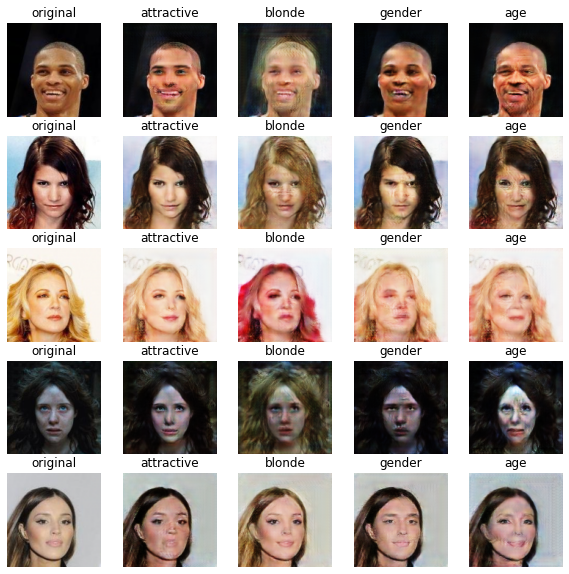

In [15]:
fig = plt.figure(figsize=(10,10))

cnt = 0
strs = ["original","black hair","blond hair","gender","age"]
for k in range(25):
    ax = fig.add_subplot(5, 5, k+1)
    if k%5 == 0:
        img = fixed_image[cnt].cpu()
    else:
        img = img_list[-1][cnt]
        cnt = cnt + 1
    ax.set_title(strs[k%5])
    ax.imshow(ImgForPlot(img))
    ax.axis("off")

plt.show()

## Save models and lists

In [13]:
model_name = 'StarGAN_CelebA_v1'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
fixed_path = F"{model_saved_dir}/{model_name}_fixed.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

torch.save(netG.state_dict(), G_path)
torch.save(netD.state_dict(), D_path)

with open(img_list_path, 'wb') as f:
    pickle.dump(img_list, f)
with open(losses_path, 'wb') as f:
    pickle.dump((G_losses, D_losses), f)
with open(fixed_path, 'wb') as f:
    pickle.dump((fixed_image, fixed_label), f)
    
print("Saved models completely!")

Saved models completely!


## Loss

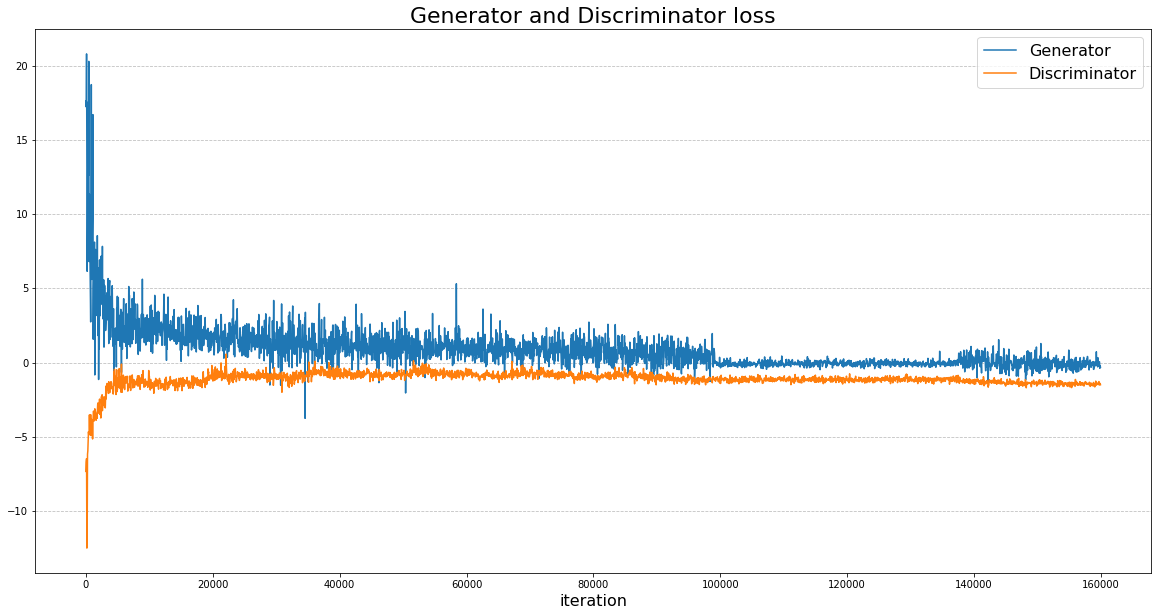

In [28]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(range(0,50*len(G_losses),50), G_losses)
plt.plot(range(0,50*len(D_losses),50), D_losses)

plt.legend(["Generator", "Discriminator"])
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.title("Generator and Discriminator loss", fontsize=22)
plt.xlabel("iteration", fontsize=16)
plt.show()

# Test

## Generate images

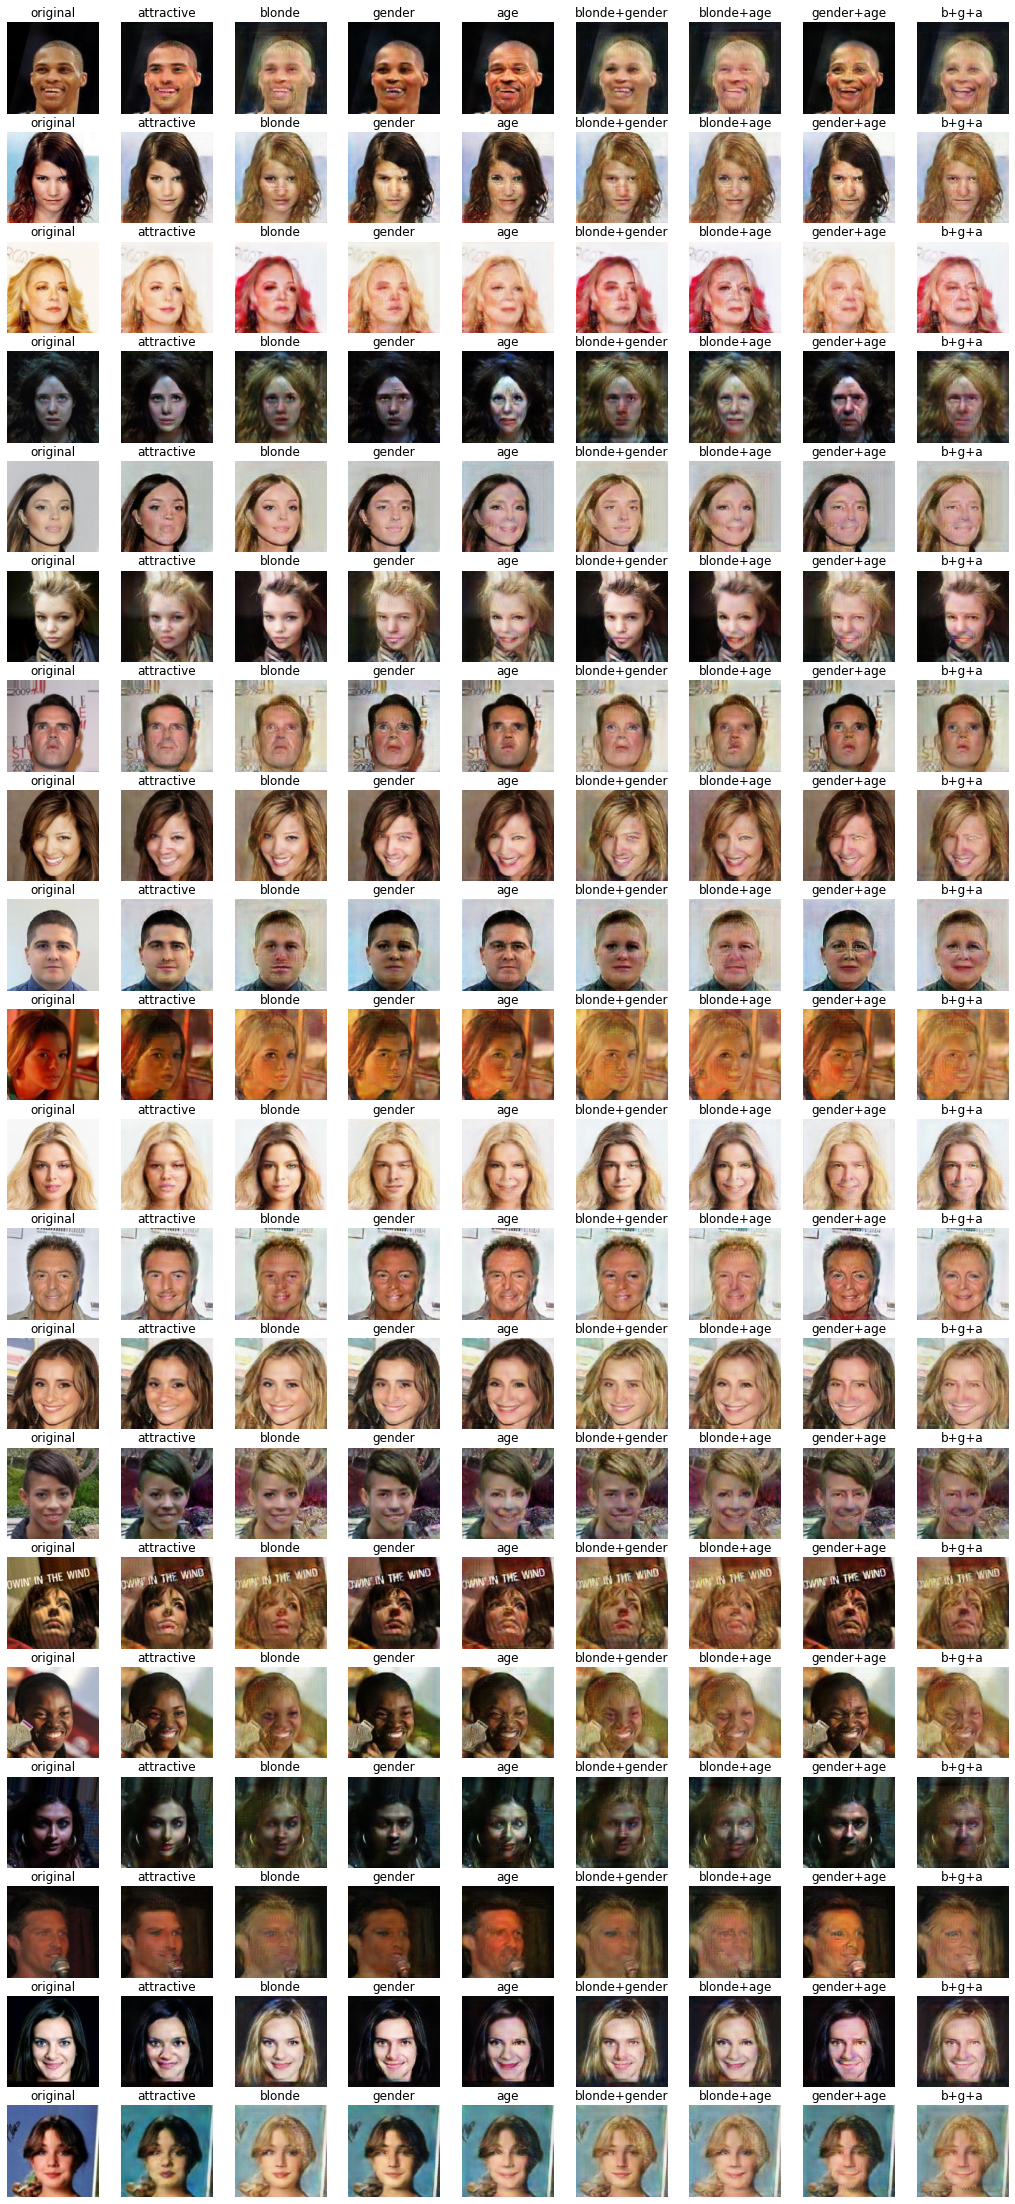

In [16]:
n_img = 20

test_image = []
test_label = []

for i in range(n_img):
    img, label = dataset[i]
    
    for j in range(8):
        test_image.append(img)
        
    for j in range(4):
        label[j] = 1.0 - label[j]
        test_label.append(label.clone().detach())
        label[j] = 1.0 - label[j]
        
    label[1] = 1.0 - label[1]
    label[2] = 1.0 - label[2]
    test_label.append(label.clone().detach()) #1,2
    label[2] = 1.0 - label[2]
    label[3] = 1.0 - label[3]
    test_label.append(label.clone().detach()) #1,3
    label[1] = 1.0 - label[1]
    label[2] = 1.0 - label[2]
    test_label.append(label.clone().detach()) #2,3
    label[1] = 1.0 - label[1]
    test_label.append(label.clone().detach()) #1,2,3
    
test_image = torch.stack(test_image).cuda()
test_label = torch.stack(test_label).cuda()

with torch.no_grad():
    output_image = netG(test_image, test_label).detach().cpu()

    
cnt = 0
strs = ["original","attractive","blonde","gender","age","blonde+gender","blonde+age","gender+age","b+g+a"]

fig = plt.figure(figsize=(2*len(strs), 2*n_img))
for k in range(n_img*len(strs)):
    ax = fig.add_subplot(n_img, len(strs), k+1)
    if k%len(strs) == 0:
        img = test_image[cnt].cpu()
    else:
        img = output_image[cnt]
        cnt = cnt + 1
    ax.set_title(strs[k%len(strs)])
    ax.imshow(ImgForPlot(img))
    ax.axis("off")

plt.show()

## Change only one character (blonde / gender / age)

In [15]:
n_img = 100

strs1 = ["blonde", "male", "young"]
strs2 = ["not_blonde", "female", "old"]

for c in range(1,4):
    test_image_1, test_label_1 = [], []
    test_image_2, test_label_2 = [], []

    for i in range(len(dataset)):
        img, label = dataset[i]
        label[c] = 1.0 - label[c]

        if label[c] < 0.5:
            if len(test_label_1) < n_img:
                test_image_1.append(img)
                test_label_1.append(label)

        else:
            if len(test_label_2) < n_img:
                test_image_2.append(img)
                test_label_2.append(label)

        if len(test_label_1) == n_img and len(test_label_2) == n_img:
            break

    # cpu -> gpu
    test_image_1 = torch.stack(test_image_1).cuda()
    test_label_1 = torch.stack(test_label_1).cuda()
    test_image_2 = torch.stack(test_image_2).cuda()
    test_label_2 = torch.stack(test_label_2).cuda()

    with torch.no_grad():
        output_1 = netG(test_image_1, test_label_1).detach().cpu()
        output_2 = netG(test_image_2, test_label_2).detach().cpu()

    print("%s -> %s" % (strs1[c-1], strs2[c-1]), end=": ")
    fig = plt.figure(figsize=(20, 2*(n_img//5)))
    for k in range(n_img):
        ax = fig.add_subplot(n_img//5, 10, 2*k+1)
        ax.imshow(ImgForPlot(test_image_1[k].cpu()))
        ax.set_title('original')
        ax.axis("off")

        ax = fig.add_subplot(n_img//5, 10, 2*k+2)
        ax.imshow(ImgForPlot(output_1[k]))
        ax.set_title('generated')
        ax.axis("off")
    plt.savefig(F"./images/{strs1[c-1]}2{strs2[c-1]}.png")
    print("Saved completed")
    plt.close(fig)
    
    print("%s -> %s" % (strs2[c-1], strs1[c-1]), end=": ")
    fig = plt.figure(figsize=(20, 2*(n_img//5)))
    for k in range(n_img):
        ax = fig.add_subplot(n_img//5, 10, 2*k+1)
        ax.imshow(ImgForPlot(test_image_2[k].cpu()))
        ax.set_title('original')
        ax.axis("off")

        ax = fig.add_subplot(n_img//5, 10, 2*k+2)
        ax.imshow(ImgForPlot(output_2[k]))
        ax.set_title('generated')
        ax.axis("off")
    plt.savefig(F"./images/{strs2[c-1]}2{strs1[c-1]}.png")
    print("Saved completed")
    plt.close(fig)

blonde -> not_blonde: Saved completed
not_blonde -> blonde: Saved completed
male -> female: Saved completed
female -> male: Saved completed
young -> old: Saved completed
old -> young: Saved completed


## Change an image linearly

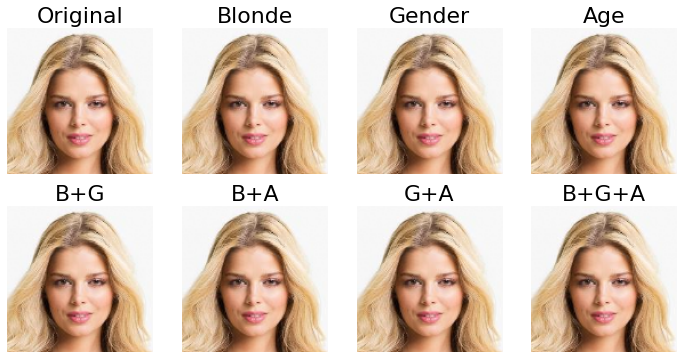

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

img_id = 10
change_lbls = [[],[1],[2],[3],[1,2],[1,3],[2,3],[1,2,3]]

change_time = 2000   # ms
stop_time = 700
fps = 30
n_steps = int(change_time*fps/1000)
stop_steps = int(stop_time*fps/1000)

s_img, s_lbl = dataset[img_id]
e_lbls = []
for k in range(8):
    e_lbl = torch.zeros(s_lbl.size(0))
    for i in range(4):
        if i in change_lbls[k]:
            e_lbl[i] = 1 - s_lbl[i]
        else:
            e_lbl[i] = s_lbl[i]
    e_lbls.append(e_lbl.clone().detach())
    
input_imgs, input_lbls = [], []
for k in range(8):
    input_img, input_lbl = [], []
    for step in range(n_steps+1):
        ratio = step/n_steps
        input_img.append(s_img)
        temp_lbl = (1.0-ratio)*s_lbl + ratio*e_lbls[k]
        input_lbl.append(temp_lbl)

    for step in range(stop_steps):
        input_img.append(s_img)
        input_lbl.append(e_lbls[k])

    for step in range(n_steps+1):
        ratio = step/n_steps
        input_img.append(s_img)
        temp_lbl = ratio*s_lbl + (1.0-ratio)*e_lbls[k]
        input_lbl.append(temp_lbl)
        
    for step in range(stop_steps):
        input_img.append(s_img)
        input_lbl.append(s_lbl)
                    
    input_img = torch.stack(input_img)
    input_lbl = torch.stack(input_lbl)
    
    input_imgs.append(input_img)
    input_lbls.append(input_lbl)
    
output_imgs = []
with torch.no_grad():
    for k in range(8):
        input_img = input_imgs[k].cuda()
        input_lbl = input_lbls[k].cuda()
        output_img = netG(input_img, input_lbl).cpu().detach().numpy()
        output_imgs.append(output_img)
        
fig = plt.figure(figsize=(12, 6))
ims = []
strs = ["Original", "Blonde", "Gender", "Age", "B+G", "B+A", "G+A", "B+G+A"]
for j in range(8):
    ax = fig.add_subplot(2, 4, j+1)
    im = ax.imshow(ImgForPlot(s_img))
    ax.axis("off")
    ax.set_title(strs[j], fontsize=22)
    ims.append(im)

def init():
    for j in range(8):
        ims[j].set_data(ImgForPlot(s_img))

    return tuple(ims)

def update(frame):   
    for j in range(8):
        ims[j].set_array(ImgForPlot(output_imgs[j][frame]))

    return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=10, blit=True, frames=output_imgs[0].shape[0])

plt.show()
clear_output(wait = True)

ani.save('./images/test1.gif', writer='pillow', fps=fps)

## Change an image linearly (2) - several times

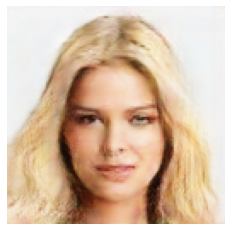

In [57]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

img_id = 10
change_lbls = [[1],[1,2],[1,2,3],[2,3],[3],[]]
change_time = 1500   # ms
stop_time = 500
fps = 30
n_steps = int(change_time*fps/1000)
n_steps_stop = int(stop_time*fps/1000)

s_img, s_lbl = dataset[img_id]
lbls = []
lbls.append(s_lbl)
for k in range(len(change_lbls)):
    temp_lbl = torch.zeros(s_lbl.size(0))    
    for i in range(4):
        if i in change_lbls[k]:
            temp_lbl[i] = 1 - s_lbl[i]
        else:
            temp_lbl[i] = s_lbl[i]
    lbls.append(temp_lbl.clone().detach())

input_img, input_lbl = [], []
for k in range(len(change_lbls)):
    for step in range(n_steps+1):
        input_img.append(s_img)
        ratio = step/n_steps
        temp_lbl = (1.0-ratio)*lbls[k] + ratio*lbls[k+1]
        input_lbl.append(temp_lbl)
    for step in range(n_steps_stop):
        input_img.append(s_img)
        input_lbl.append(lbls[k+1])
        
input_img = torch.stack(input_img).cuda()
input_lbl = torch.stack(input_lbl).cuda()

with torch.no_grad():
    output_img = netG(input_img, input_lbl).cpu().detach().numpy()
    
fig = plt.figure(figsize=(4, 4))
im = plt.imshow(ImgForPlot(output_img[0]))
plt.axis('off')

def init():
    im.set_data(ImgForPlot(output_img[0]))
    return [im]

def update(frame):
    img = output_img[frame].tolist()
    im.set_array(ImgForPlot(img))

    return [im]

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=1000/fps, blit=True, frames=range(input_img.size(0)))

plt.show()
clear_output(wait = True)

ani.save('./images/test2.gif', writer='pillow', fps=fps)

## Change images linearly (several inputs)

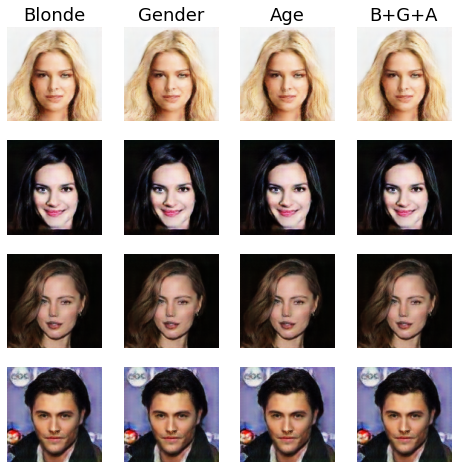

In [29]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

img_ids = [10, 18, 43, 46]
change_lbls = [[1],[2],[3],[1,2,3]]

change_time = 2000   # ms
stop_time = 700
fps = 30
n_steps = int(change_time*fps/1000)
stop_steps = int(stop_time*fps/1000)

input_imgs, input_lbls = [], []

for img_id in img_ids:
    s_img, s_lbl = dataset[img_id]
    
    e_lbls = []
    for lbl in change_lbls:
        e_lbl = torch.zeros(s_lbl.size(0))
        for i in range(4):
            if i in lbl:
                e_lbl[i] = 1 - s_lbl[i]
            else:
                e_lbl[i] = s_lbl[i]
        e_lbls.append(e_lbl.clone().detach())
    
    for k in range(len(change_lbls)):
        input_img, input_lbl = [], []
        for step in range(n_steps+1):
            ratio = step/n_steps
            input_img.append(s_img)
            temp_lbl = (1.0-ratio)*s_lbl + ratio*e_lbls[k]
            input_lbl.append(temp_lbl)

        for step in range(stop_steps):
            input_img.append(s_img)
            input_lbl.append(e_lbls[k])

        for step in range(n_steps+1):
            ratio = step/n_steps
            input_img.append(s_img)
            temp_lbl = ratio*s_lbl + (1.0-ratio)*e_lbls[k]
            input_lbl.append(temp_lbl)

        for step in range(stop_steps):
            input_img.append(s_img)
            input_lbl.append(s_lbl)

        input_img = torch.stack(input_img)
        input_lbl = torch.stack(input_lbl)

        input_imgs.append(input_img)
        input_lbls.append(input_lbl)
    
output_imgs = []
with torch.no_grad():
    for k in range(len(input_imgs)):
        input_img = input_imgs[k].cuda()
        input_lbl = input_lbls[k].cuda()
        output_img = netG(input_img, input_lbl).cpu().detach().numpy()
        output_imgs.append(output_img)
    
fig = plt.figure(figsize=(2*len(change_lbls), 2*len(img_ids)))
ims = []
strs = ["Blonde", "Gender", "Age", "B+G+A"]
for j in range(len(change_lbls)*len(img_ids)):
    ax = fig.add_subplot(len(img_ids), len(change_lbls), j+1)
    im = ax.imshow(ImgForPlot(output_imgs[j][0]))
    ax.axis("off")
    if j < len(strs):
        ax.set_title(strs[j], fontsize=18)
    ims.append(im)

def init():
    for j in range(len(change_lbls)*len(img_ids)):
        ims[j].set_data(ImgForPlot(output_imgs[j][0]))

    return tuple(ims)

def update(frame):   
    for j in range(len(change_lbls)*len(img_ids)):
        ims[j].set_array(ImgForPlot(output_imgs[j][frame]))

    return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=10, blit=True, frames=output_imgs[0].shape[0])

plt.show()
clear_output(wait = True)

ani.save('./images/test3.gif', writer='pillow', fps=fps)

## Change an image not in dataset

In [ ]:
# Attractive, Blonde, Male, Young
input_label = []
img_path = "./images/myimage.png"

input_image = transform(cv2.imread(img_path)).unsqueeze_(0)

input_image = input_image.cuda()
input_label = input_label.cuda()

with torch.no_grad()
    output_img = netG(input_image, input_label).detach()[0].cpu()

    
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax.imshow(ImgForPlot(input_image.cpu()))
ax.set_title("Input image")
ax.axis("off")

ax = fig.add_subplot(1,2,2)
ax.imshow(ImgForPlot(output_img.cpu()))
ax.set_title("Generated image")
ax.axis("off")

plt.plot()

## Change a gif file

In [16]:
import cv2

def GifToFrame(path, crop=None, transform=None): 
    frames, masks = [], []
    gif = cv2.VideoCapture(gif_path)
    fps = gif.get(cv2.CAP_PROP_FPS)
    
    while True:
        ret, frame = gif.read()
        if ret:
            if crop:
                x1, x2, y1, y2 = crop
                frame = frame[y1:y2,x1:x2]
                
            if transform:
                frames.append(transform(frame))
            else:
                frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
        else:
            break
            
    flag = 1 if transform else 0
    
    print("GIF Info: %dx%d, %d frames, %d fps" % 
          (frames[0].shape[flag], frames[0].shape[1+flag], len(frames), fps))
    
    return frames, fps

GIF Info: 500x615, 37 frames, 20 fps
GIF Info: 128x128, 37 frames, 20 fps


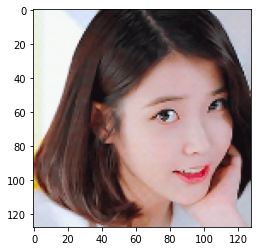

Save resized gif completely.
Save generated gif completely.
Save combined gif completely.


In [24]:
import imageio, numpy as np

# Attractive, Blonde, Male, Young
input_label = [0, 1, 0, 1]
gif_path = "./images/iu/iu.gif"
x1, x2, y1, y2 = 150, 450, 50, 350

#elon.gif:  x1, x2, y1, y2 = 150, 438, 0, 288
#elon2.gif: x1, x2, y1, y2 = 50, 208, 0, 158

original, _ = GifToFrame(gif_path)
resize, fps = GifToFrame(gif_path, (x1, x2, y1, y2), transform)

plt.imshow(ImgForPlot(resize[0]))
plt.show()

# Save Resize GIF
resize_path = gif_path.replace(".gif","-resize.gif")
imageio.mimsave(resize_path, [ImgForPlot(f) for f in resize], format='GIF', fps=fps)
print("Save resized gif completely.")


# Change frames with generator
labels = [torch.tensor(input_label, dtype=torch.float32) for i in range(len(resize))]
labels = torch.stack(labels).cuda()
inputs = torch.stack(resize).cuda()

with torch.no_grad():
    outputs = netG(inputs, labels).cpu().detach().numpy()

# Save Generated GIF
outputs = [ImgForPlot(o) for o in outputs]
gen_path = gif_path.replace(".gif","-generated.gif")
imageio.mimsave(gen_path, outputs, format='GIF', fps=fps)
print("Save generated gif completely.")

combs = []
for i in range(len(outputs)):
    comb = np.ndarray((128,256,3), dtype=np.uint8)
    comb[:, 0:128] = ImgForPlot(resize[i])
    comb[:, 128:256] = outputs[i]
    combs.append(comb)

comb_path = gif_path.replace(".gif","-combined.gif")
imageio.mimsave(comb_path, combs, format='GIF', fps=fps)
print("Save combined gif completely.")